---
title: "Predicting Customer Satisfaction"
author: Ευάγγελος Δημητρίου        
date: February 17, 2025
---

vagdimi6@gmail.com

In this project, we explore the application of predictive modeling to address a common challenge faced by many service providers, which is *Customer Satisfaction*. The focus is on analyzing data related to airline passenger satisfaction to develop a model that can effectively predict customer satisfaction levels. This report outlines the methodology and findings of our analysis, aiming to provide insights that can be applied broadly across various industries.
 



### Understanding the Data

- Initial Overview:

  We examine the datasets provided in train.csv and test.csv:
  - How many rows and columns do they contain?
  
  - What are their features?
  
  - Are there labels for classification in the train.csv file?
  
  - What are the data types (numerical, categorical, dates, etc.)?
  
  - Analyze basic statistics (mean, variance, etc.) for numerical data.
  
  - Investigate any potential missing values.



In [81]:
# Importing necessary libraries
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.naive_bayes import GaussianNB
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import roc_auc_score, accuracy_score, classification_report, confusion_matrix, ConfusionMatrixDisplay, roc_curve, auc
from sklearn.preprocessing import StandardScaler
from typing import Tuple


In [82]:
# Reading training data from .csv file
train_data = pd.read_csv('train.csv')


# Basic Analysis
print("\n~~Trian Head~~\n")
print(train_data.head())

print("\n~~Train info~~\n")
print(train_data.info())

print("\n~~Train describe~~\n")
print(train_data.describe())

# Nan values
print("\n~~Train isnull.sum~~\n")
print(train_data.isnull().sum())



~~Trian Head~~

   Unnamed: 0      id  Gender      Customer Type  Age   Type of Travel  \
0           0   70172    Male     Loyal Customer   13  Personal Travel   
1           1    5047    Male  disloyal Customer   25  Business travel   
2           2  110028  Female     Loyal Customer   26  Business travel   
3           3   24026  Female     Loyal Customer   25  Business travel   
4           4  119299    Male     Loyal Customer   61  Business travel   

      Class  Flight Distance  Inflight wifi service  \
0  Eco Plus              460                      3   
1  Business              235                      3   
2  Business             1142                      2   
3  Business              562                      2   
4  Business              214                      3   

   Departure/Arrival time convenient  ...  Inflight entertainment  \
0                                  4  ...                       5   
1                                  2  ...                       1   


In [83]:
# Read test data from .csv file
test_data = pd.read_csv('test.csv')

# Basic Analysis

print("\n~~Test Head~~\n")
print(test_data.head())

print("\n~~Test info~~\n")
print(test_data.info())

print("\n~~Test describe~~\n")
print(test_data.describe())

# Nan values
print("\n~~Test isnull.sum~~\n")
print(test_data.isnull().sum())



~~Test Head~~

   Unnamed: 0     id  Gender      Customer Type  Age   Type of Travel  \
0           0  19556  Female     Loyal Customer   52  Business travel   
1           1  90035  Female     Loyal Customer   36  Business travel   
2           2  12360    Male  disloyal Customer   20  Business travel   
3           3  77959    Male     Loyal Customer   44  Business travel   
4           4  36875  Female     Loyal Customer   49  Business travel   

      Class  Flight Distance  Inflight wifi service  \
0       Eco              160                      5   
1  Business             2863                      1   
2       Eco              192                      2   
3  Business             3377                      0   
4       Eco             1182                      2   

   Departure/Arrival time convenient  ...  Inflight entertainment  \
0                                  4  ...                       5   
1                                  1  ...                       4   
2      

In [84]:
# Statistics of categorical variables
print("\n~~Gender.value_counts~~\n")
print(train_data['Gender'].value_counts())

print("\n~~satisfaction.value_counts~~\n")
print(train_data['satisfaction'].value_counts())

print("\n~~Customer Type.value_counts~~\n")
print(train_data['Customer Type'].value_counts())

print("\n~~Class.value_counts~~\n")
print(train_data['Class'].value_counts())

print("\n~~Type of Travel.value_counts~~\n")
print(train_data['Type of Travel'].value_counts())



~~Gender.value_counts~~

Gender
Female    52727
Male      51177
Name: count, dtype: int64

~~satisfaction.value_counts~~

satisfaction
neutral or dissatisfied    58879
satisfied                  45025
Name: count, dtype: int64

~~Customer Type.value_counts~~

Customer Type
Loyal Customer       84923
disloyal Customer    18981
Name: count, dtype: int64

~~Class.value_counts~~

Class
Business    49665
Eco         46745
Eco Plus     7494
Name: count, dtype: int64

~~Type of Travel.value_counts~~

Type of Travel
Business travel    71655
Personal Travel    32249
Name: count, dtype: int64


#### Consistent Data Formats

Maintaining consistent quality and structure in input data is crucial for a predictive model because:

1. **Prediction Accuracy**: Inconsistent or incorrect data can lead to errors in the model, resulting in unreliable or misleading predictions.

2. **Generalization**: A model trained on consistent data is more likely to learn genuine patterns and perform well on new data.

3. **Avoiding Bias**: Inconsistencies in data (e.g., missing or distorted values) can introduce systematic biases, negatively affecting the model's performance.

4. **Comparison and Reproducibility**: Consistency in data is necessary to compare different models or replicate experiments.

5. **Reliability and Transparency**: Consistency ensures that the model's predictions are based on stable and understandable rules, which is important for transparency and interpretability.

In particular, for some categorical variables in the dataset, we observe inconsistencies in the use of uppercase and lowercase strings. Therefore, we will make some adjustments to achieve consistency and continuity in our data.

In [85]:
# Convert the "Customer Type" variable
train_data['Customer Type'] = train_data['Customer Type'].str.lower()
test_data['Customer Type'] = test_data['Customer Type'].str.lower()

# Convert the "Type of Travel" variable
train_data['Type of Travel'] = train_data['Type of Travel'].str.lower()
test_data['Type of Travel'] = test_data['Type of Travel'].str.lower()


#### Data Cleaning and Transformation

Based on the training data presented above, several steps are necessary to prepare the data for use in our models. There are multiple categorical variables that need to be encoded, including our target variable, *`"Satisfaction"`*. Additionally, some columns are redundant, such as *`"Unnamed: 0"`* and *`"id"`*, and can be removed. The following functions will be used to prepare the dataset.

In [86]:
# Transformation function of the categorical variable "satisfaction"
def transform_satisfaction(x):
    if x == 'satisfied':
        return 1
    elif x == 'neutral or dissatisfied':
        return 0
    else:
        return -1

#------------------------------------------------------------------------

# Transformation function of the categorical variable "Gender"
def transform_gender(x):
    if x == 'Female':
        return 1
    elif x == 'Male':
        return 0
    else:
        return -1

#------------------------------------------------------------------------

# Transformation function of the categorical variable "Customer Type"
def transform_customer_type(x):
    if x == 'loyal customer':
        return 1
    elif x == 'disloyal customer':
        return 0
    else:
        return -1
    
#------------------------------------------------------------------------

# Transformation function of the categorical variable "Class"
def transform_class(x):
    if x == 'Business':
        return 2
    elif x == 'Eco Plus':
        return 1
    elif x == 'Eco':
        return 0
    else:
        return -1

#------------------------------------------------------------------------

# Transformation function of the categorical variable "Type of Travel"
def transform_type_of_travel(x):
    if x == 'business travel':
        return 1
    elif x == 'personal travel':
        return 0
    else:
        return -1

#------------------------------------------------------------------------

## Explanation of Functions

### **1. `transform_satisfaction`**
Converts the target variable "satisfaction" into a binary value:
- **Input**: 'satisfied', 'neutral or dissatisfied'.
- **Output**:
  - 1 for 'satisfied'.
  - 0 for 'neutral or dissatisfied'.
  - -1 for unrecognized values.
- **Use of -1**: Indicates invalid or unknown values in the target variable.

---

### **2. `transform_gender`**
Converts the "Gender" column into numerical values:
- **Input**: 'Female', 'Male'.
- **Output**:
  - 1 for 'Female'.
  - 0 for 'Male'.
  - -1 for unrecognized values.
- **Use of -1**: Allows identification of incorrect or unexpected values for further inspection.

---

### **3. `transform_customer_type`**
Converts the "Customer Type" variable into a numerical format:
- **Input**: 'loyal customer', 'disloyal customer'.
- **Output**:
  - 1 for 'loyal customer'.
  - 0 for 'disloyal customer'.
  - -1 for unrecognized values.

---

### **4. `transform_class`**
Converts the "Class" variable into a numerical format reflecting travel class hierarchy:
- **Input**: 'Business', 'Eco Plus', 'Eco'.
- **Output**:
  - 2 for 'Business'.
  - 1 for 'Eco Plus'.
  - 0 for 'Eco'.
  - -1 for unrecognized values.

---

### **5. `transform_type_of_travel`**
Converts the "Type of Travel" variable into a numerical format:
- **Input**: 'business travel', 'personal travel'.
- **Output**:
  - 1 for 'business travel'.
  - 0 for 'personal travel'.
  - -1 for unrecognized values.

---

### **Notes on the Functions**
1. **Handling Invalid Values (`else: return -1`)**:
   - The `-1` can be used to easily identify invalid or missing data.
   - Provides a mechanism for data cleaning if values outside the defined set are encountered.

2. **Multi-level Categories (`transform_class`)**:
   - Instead of a binary value, the "Class" categories have multiple values reflecting a hierarchy.
   - The absence of strictly binary values in categories is crucial in choosing classifiers.

3. **Consistency in Outputs**:
   - All functions return integer values, making the dataset more compatible with machine learning algorithms.

---

#### Applying the Functions

Our functions are ready to transform the variables. The method *`.apply()`*, which takes a function as an argument, applies the function to a **`Pandas Series`**. However, we must also consider other transformations:

1. The method `.drop()` takes as an argument, here in list form, the names of the variables that are redundant, as described above: *`"Unnamed: 0", "id"`*, and removes them from the DataFrame. The argument *`axis=1`* indicates the axis along which the deletions will occur, with the value *`1`* signifying that this axis is the column axis in the DataFrame.

2. Earlier, we observed missing values in the "Arrival Delay in Minutes" variable. We can address these using various methods:
   - Removing all rows where they appear,
   - Replacing the **null** values with a specific value using the *`.fillna()`* method, or
   - Leaving these rows untouched.

   We will opt to replace the **null** values with a specific value using the *`.fillna()`* method. Instead of arbitrarily assigning an integer value to the missing values, we will calculate the median value of the variable within *.fillna()* using the *`.median()`* method.

Using the logic of these functions, we can transform both the training and evaluation data simultaneously:


In [87]:
# Function process_data(df):
def preprocess_data(df):
    df = df.drop(['Unnamed: 0', 'id'], axis=1) # Remove unnecessary columns
    df['Gender'] = df['Gender'].apply(transform_gender) # Convert categorical variables
    df['Customer Type'] = df['Customer Type'].apply(transform_customer_type) # Convert categorical variables
    df['Type of Travel'] = df['Type of Travel'].apply(transform_type_of_travel) # Convert categorical variables
    df['Class'] = df['Class'].apply(transform_class) # Convert categorical variables
    df['satisfaction'] = df['satisfaction'].apply(transform_satisfaction) # Convert the target variable
    df['Arrival Delay in Minutes'] = df['Arrival Delay in Minutes'].fillna(df['Arrival Delay in Minutes'].median()) # Handling missing values
    
    return df # Return the processed DataFrame



### **Summary of the `preprocess_data(df)` Function**

The function:

1. Removes unnecessary columns.
2. Converts categorical variables into numerical format.
3. Replaces missing values.
4. Encodes the target variable.
5. Returns a clean and processed DataFrame ready for model training.


In [88]:
# Transform data
train_processed = preprocess_data(train_data) # This line applies the `preprocess_data()` function to the training data set `train`.
test_processed = preprocess_data(test_data) # This line performs the same process for the estimate data (`test`).


#### **Purpose of the Process:**

- **Data Preparation**: The `preprocess_data()` function ensures that both the training and evaluation datasets are in a suitable format for use by machine learning algorithms.

- **Uniformity**: Categorical variables are converted into numerical features, and missing values are handled, ensuring that machine learning algorithms can process them without issues.

#### **Key Points:**

- **Training and Evaluation**: It is crucial that the exact same transformation is applied to the evaluation data (`test`) so that the model processes the data in the same way as the training data.

- **Necessary Preparation**: Transforming data into a numerical format is critical for the proper training and evaluation of the model.

## **Data Mining and Prediction Design**

### **Data Mining**

- Questions We Can Answer:

  - Which features have the greatest impact on a particular outcome?

  - Are there clusters of data that share similar characteristics?

#### **Methodology:**

1. Correlation Analysis:
   - Calculate the correlation between features using the *`.corr()`* method. We will test two correlation coefficients:
     - Pearson (by setting the argument *`method='pearson'`*)
     - Spearman (by setting the argument *`method='spearman'`*)

2. Data Visualization:
   - Use charts to detect relationships.

#### **Imbalanced Data**

First, let's examine whether the classes of the target variable "satisfaction" in the training data are balanced. Simply using a *`sns.barplot()`* can visualize the actual numbers of the two classes and show how many samples exist in each category. Finally, a *`plt.pie()`* provides a clear picture of the category proportions.

Absolute frequencies of each class:
satisfaction
Unsatisfied    58879
Satisfied      45025
Name: count, dtype: int64

Percentages of each class:
satisfaction
Unsatisfied    56.67
Satisfied      43.33
Name: count, dtype: float64


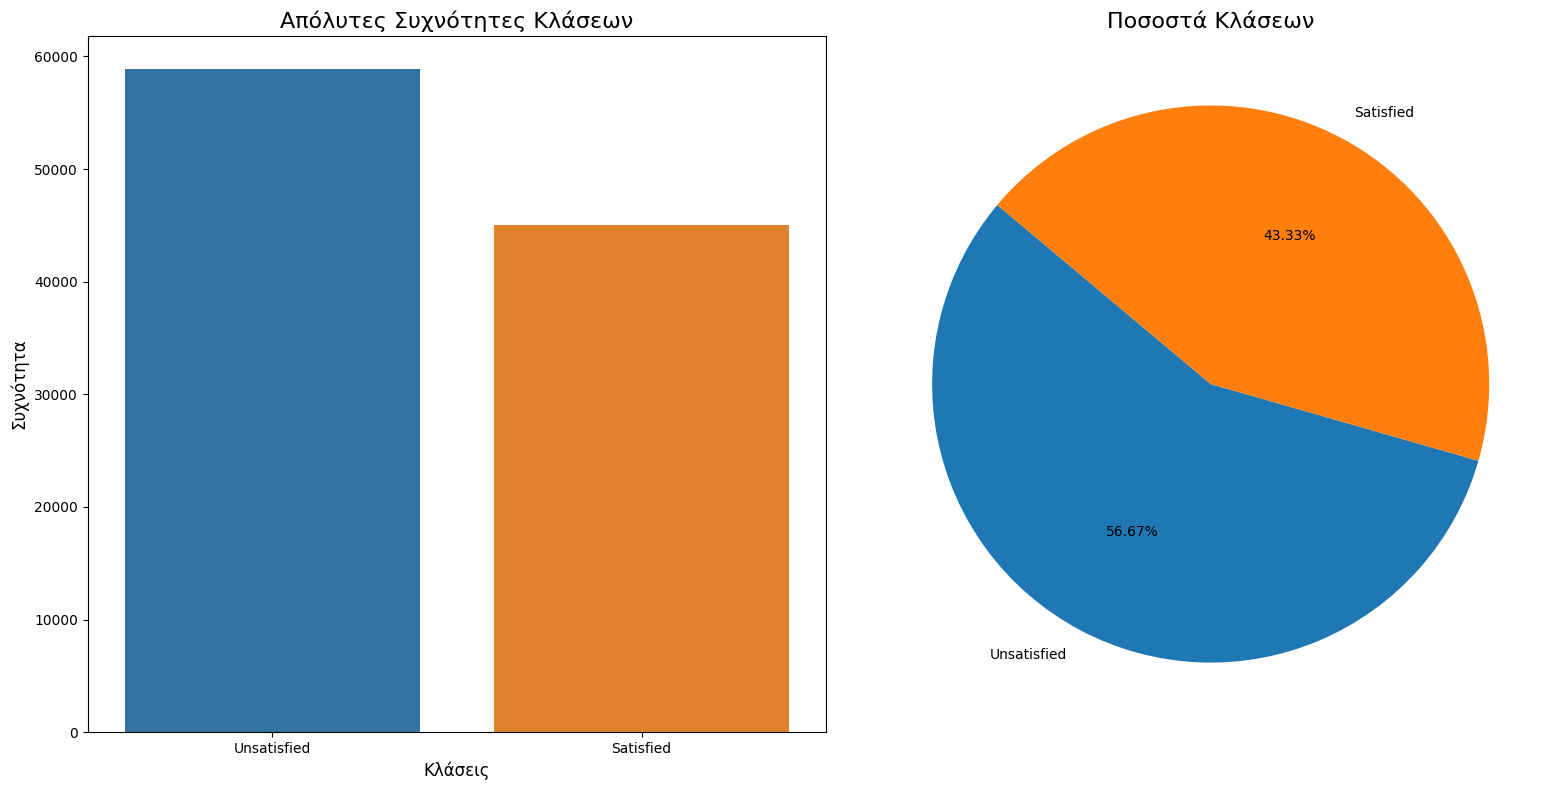

In [89]:
# Calculation of frequencies for the target variable "satisfaction"
class_counts = train_processed['satisfaction'].value_counts()
class_counts.index = class_counts.index.map({1: 'Satisfied', 0: 'Unsatisfied'})

# Show absolute and percentage values
print("Absolute frequencies of each class:")
print(class_counts)

print("\nPercentages of each class:")
print(round((class_counts / len(train_processed) * 100), 2))

# Create the figure and the subplots
fig, axes = plt.subplots(1, 2, figsize=(16, 8))

# Bar plot - absolute values
sns.barplot(ax=axes[0], x=class_counts.index, y=class_counts.values, hue=class_counts.index, palette="tab10", legend=False)
axes[0].set_title("Απόλυτες Συχνότητες Κλάσεων", fontsize=16)
axes[0].set_xlabel("Κλάσεις", fontsize=12)
axes[0].set_ylabel("Συχνότητα", fontsize=12)

# Pie chart - percentage values
axes[1].pie(class_counts.values, labels=class_counts.index, autopct='%1.2f%%', startangle=140, colors=sns.color_palette("tab10"))
axes[1].set_title("Ποσοστά Κλάσεων", fontsize=16)


plt.tight_layout()
plt.show()


##### **Conclusion:**
From the graphs, it appears that the target variable "satisfaction" is quite balanced and there is no need to apply further sampling or other techniques.

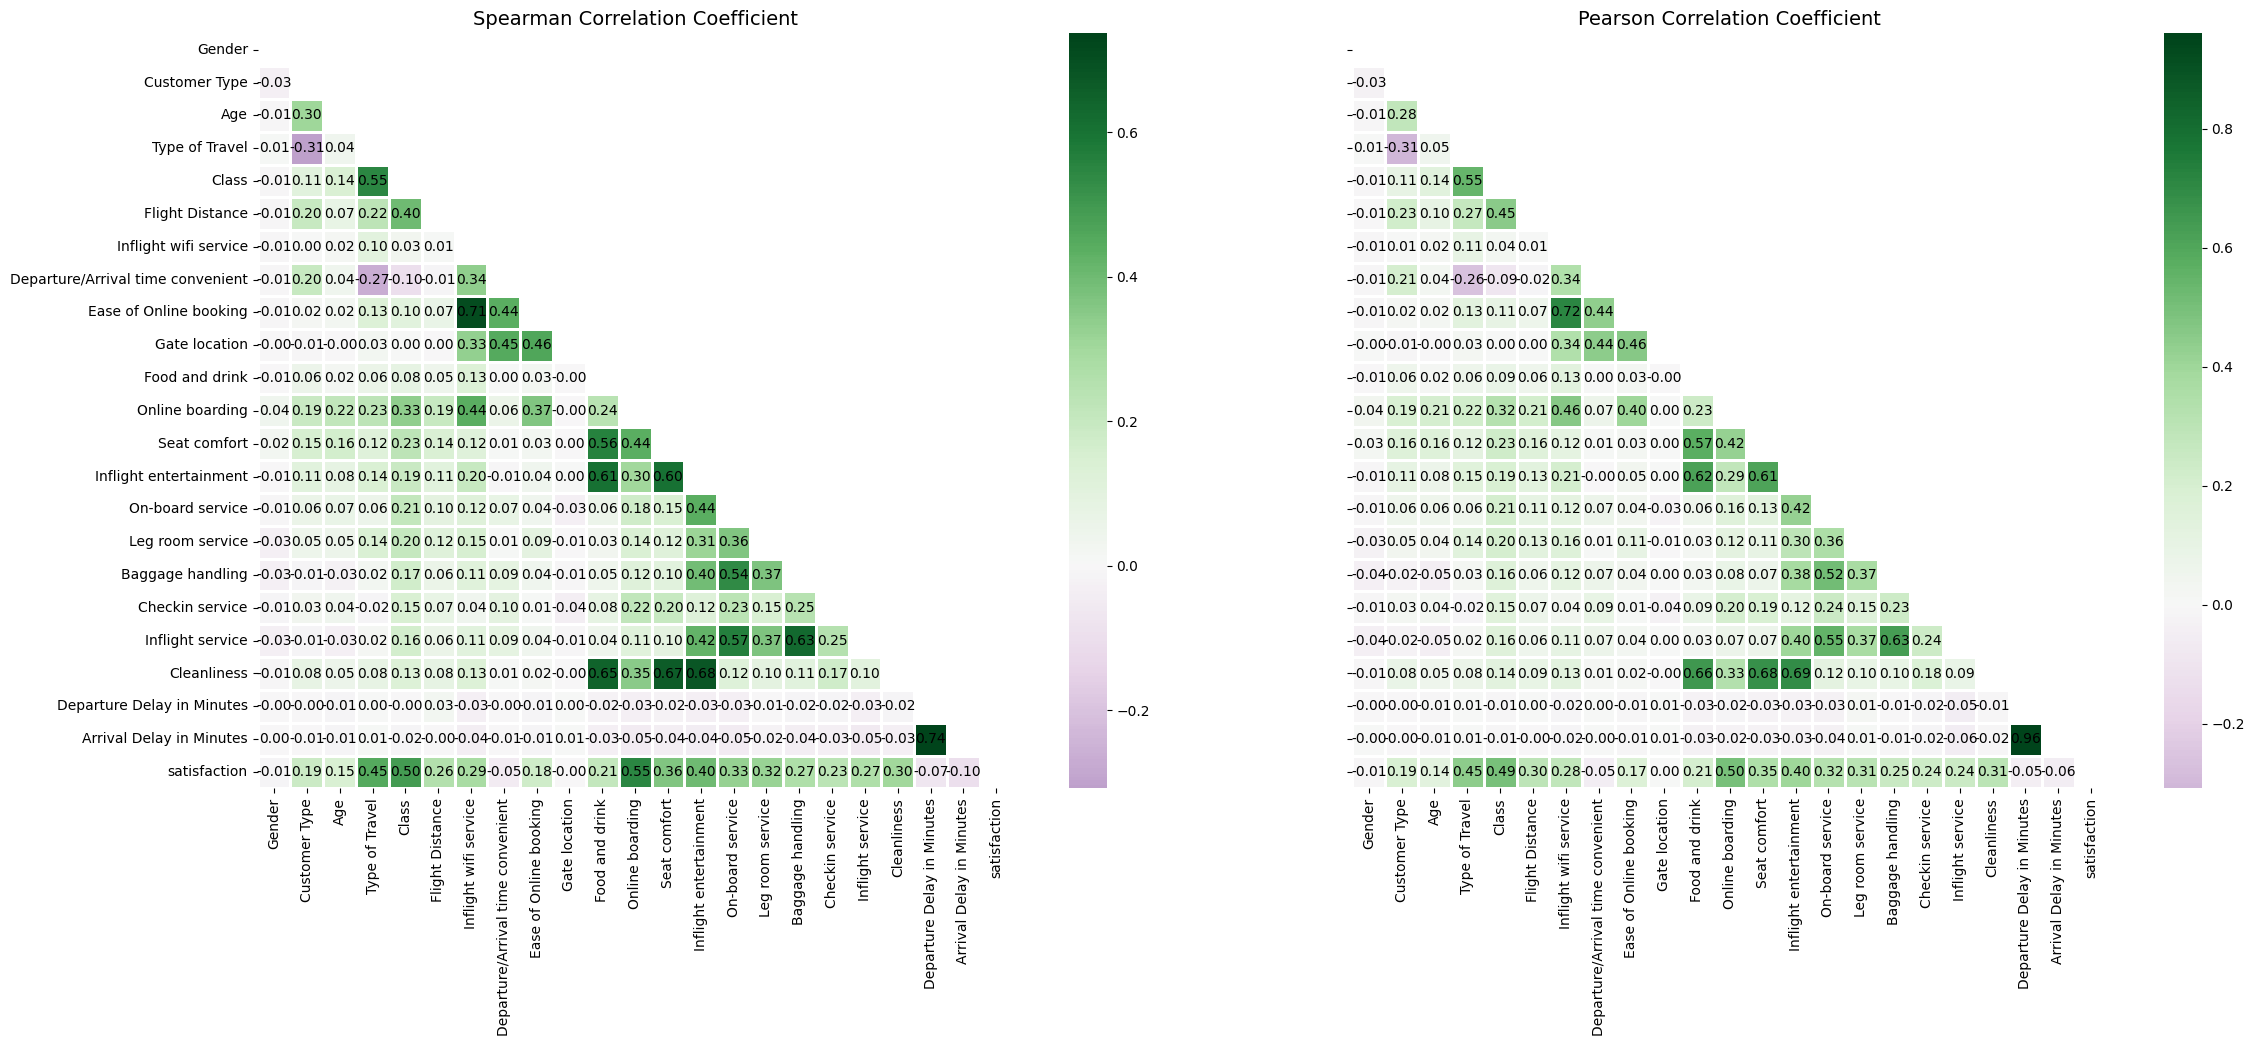

In [107]:
# Calculate correlations
# Pearson correlation coefficient
corr_pearson = train_processed.corr(method='pearson')
# Spearman correlation coefficient
corr_spearman = train_processed.corr(method='spearman')

# GRAPHS:
# Create a mask for the upper triangular part
# The mask hides the upper triangular part of the table for more efficient visualization. 
mask = np.triu(np.ones_like(corr_spearman, dtype=bool))

# Δημιουργία υπογραφημάτων (subplots)
fig, axes = plt.subplots(1, 2, figsize=(25, 10), sharey=True)  # 1 γραμμή, 2 στήλες


# Heatmap Spearman
sns.heatmap(corr_spearman, annot=True, annot_kws={"size": 10, "color": "black"}, mask=mask, cmap='PRGn', center=0,
            square=True, linewidths=.8, ax=axes[0], fmt=".2f")
axes[0].set_title("Spearman Correlation Coefficient", fontsize=14)

# Heatmap Pearson
sns.heatmap(corr_pearson, annot=True, annot_kws={"size": 10, "color": "black"}, mask=mask, cmap='PRGn', center=0,
            square=True, linewidths=.8, ax=axes[1], fmt=".2f")
axes[1].set_title("Pearson Correlation Coefficient", fontsize=14)

plt.tight_layout()
plt.show()


#### **Computation of Correlations:**

**Spearman** (*`corr_spearman`*) and **Pearson** (*`corr_pearson`*) correlation matrices are calculated separately.

The code produces two heatmaps, one for the Spearman correlation coefficient and the other for the Pearson, placed side by side.
#### Key Insights from Correlation Matrices:

1. **Strongest Correlations with Satisfaction:**
   - **Type of Travel** and **Class** show moderate positive correlations (~0.45).
   - **Inflight service** and **Cleanliness** are also positively correlated (~0.35).

2. **Service Quality Impact:**
   - **Online boarding** and **Seat comfort** have moderate correlations (~0.33-0.35).
   - **Inflight entertainment** shows a notable correlation (~0.30).

3. **Minimal Influence:**
   - **Gender** and **Age** have negligible correlations.
   - **Delays** (departure/arrival) show very low impact on satisfaction.

4. **Consistent Patterns:**
   - Both Spearman and Pearson coefficients highlight similar influential factors, emphasizing service quality over demographic or delay factors.

### **Understanding the Problem and Choosing the appropriate Predictive Models**

Predicting customer satisfaction is a classification problem where the target variable is ***binary***, such as satisfied or unsatisfied. This means there are two possible outcomes: either *the customer is satisfied* or *the customer is not satisfied*. In this report, we will use two predictive models from two algorithms:

- **1. Gaussian Naive Bayes (GNB)**
- **2. Logistic Regression**

In [91]:
def prepare_data(train_processed: pd.DataFrame, 
                test_processed: pd.DataFrame) -> Tuple[np.ndarray, np.ndarray, np.ndarray, np.ndarray, list]:
    """
    Prepare data for model training by separating features and target,
    scaling features, and preparing class labels.
    
    Args:
        train_processed: Processed training dataset
        test_processed: Processed test dataset
    
    Returns:
        Tuple containing:
        - X_train_scaled: Scaled training features
        - X_test_scaled: Scaled testing features
        - y_train: Training target values
        - y_test: Testing target values
        - class_labels: Unique class labels
    """
    # Separate features and target
    X_train = train_processed.drop('satisfaction', axis=1)
    y_train = train_processed['satisfaction']
    
    X_test = test_processed.drop('satisfaction', axis=1)
    y_test = test_processed['satisfaction']
    
    # Create class labels
    y = y_train.map({0: 'neutral or dissatisfied', 1: 'satisfied'})
    class_labels = y.unique()
    
    # Scale features
    scaler = StandardScaler()
    X_train_scaled = scaler.fit_transform(X_train)
    X_test_scaled = scaler.transform(X_test)
    
    return X_train_scaled, X_test_scaled, y_train, y_test, class_labels

### Data Preparation Function

The `prepare_data` function is designed to prepare datasets for model training by performing the following steps:

- **Feature and Target Separation**: 
  - Splits the processed training and test datasets into features (`X_train`, `X_test`) and target values (`y_train`, `y_test`), where the target is the 'satisfaction' column.

- **Class Label Creation**: 
  - Maps the target values in `y_train` to descriptive class labels ('neutral or dissatisfied', 'satisfied') and extracts unique class labels.

- **Feature Scaling**: 
  - Applies `StandardScaler` to standardize the features, ensuring that they have a mean of 0 and a standard deviation of 1. This scaling is applied to both training and test features.

- **Returns**: 
  - A tuple containing scaled training and test features, training and test target values, and the list of unique class labels.

In [92]:
# Use the function
X_train_scaled, X_test_scaled, y_train, y_test, class_labels = prepare_data(train_processed, test_processed)

## **Prediction**

## **1. Gaussian Naive Bayes (GNB)**

In [93]:
# Build and train the Gaussian Naive Bayes classifier
gnb = GaussianNB()
gnb.fit(X_train_scaled, y_train)

GaussianNB()

In [94]:
# Predictions
y_pred = gnb.predict(X_test_scaled)

In [95]:
# Generate a random sample with values ​​from the attribute value range
np.random.seed(25)  # Set seed for reproducibility
feature_min = X_train_scaled.min(axis=0)  # Minimum values ​​per attribute
feature_max = X_train_scaled.max(axis=0)  # Maximum values ​​per attribute
random_sample = np.random.uniform(feature_min, feature_max, size=(1, X_train_scaled.shape[1]))

# Define the scaler
scaler = StandardScaler().fit(X_train_scaled)

random_sample_scaled = scaler.transform(random_sample)
predicted_class = gnb.predict(random_sample_scaled) # Uses Naive Bayes model for prediction

# Maps the numeric prediction to an interpretable string label
predicted_class_label = class_labels[predicted_class[0]]

print(f"\n\tThe forecast for the new sample: {predicted_class_label}\n")



	The forecast for the new sample: neutral or dissatisfied



Accuracy: 0.86
ROC_AUC: 0.86

	Classification Report:
              precision    recall  f1-score   support

           0       0.86      0.89      0.88     14573
           1       0.86      0.82      0.84     11403

    accuracy                           0.86     25976
   macro avg       0.86      0.86      0.86     25976
weighted avg       0.86      0.86      0.86     25976



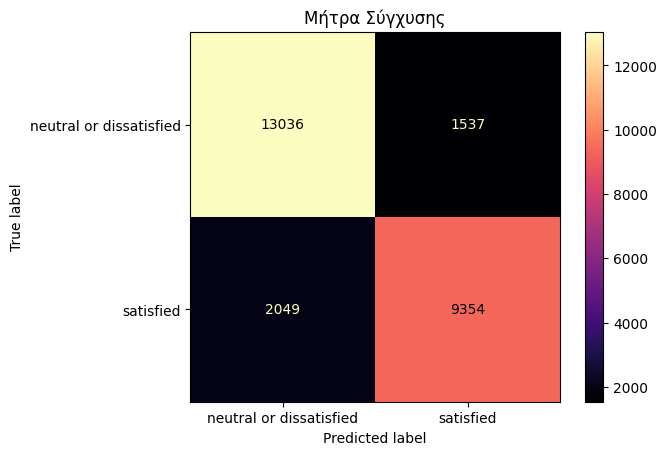

In [96]:
# Estimation and evaluation of the model
accuracy_gnb = accuracy_score(y_test, y_pred)
print(f"Accuracy: {accuracy_gnb:.2f}")

roc_auc_gnb = roc_auc_score(y_test, y_pred)
print(f"ROC_AUC: {roc_auc_gnb:.2f}")

# Print detailed classification report
print("\n\tClassification Report:")
print(classification_report(y_test, y_pred))

# Visualization 1: Confusion Matrix
conf_matrix = confusion_matrix(y_test, y_pred)
disp = ConfusionMatrixDisplay(confusion_matrix=conf_matrix, display_labels=class_labels)
disp.plot(cmap='magma')
plt.title("Μήτρα Σύγχυσης")
plt.show()


The code above evaluates and assesses the performance of the trained **Gaussian Naive Bayes** model using various metrics and indicators:

1. **Calculating Accuracy.**

2. **Calculating the ROC AUC Score.**

3. **Printing the Classification Report.**
   - **`classification_report(y_test, y_pred)`**: Prints a detailed report on the model's performance, which includes:
     - **Precision**: The accuracy of the model for each class.
     - **Recall**: The ratio of correctly detected true positive cases.
     - **F1-Score**: The harmonic mean of precision and recall.
     - **Support**: The number of observations for each class.

4. **Visualizing the Confusion Matrix.**

In [99]:
# Evaluating the importance of features in prediction
# Using the average variance of each feature for each class
feature_importance = pd.DataFrame({
    'Feature': X_train.columns,
    'Mean Variance': np.mean(gnb.var_, axis=0)
})
feature_importance = feature_importance.sort_values('Mean Variance', ascending=True)

print("\nCharacteristic importance based on mean variance:")
print(feature_importance)


Characteristic importance based on mean variance:
                              Feature  Mean Variance
3                      Type of Travel       0.741582
4                               Class       0.746719
11                    Online boarding       0.750341
13             Inflight entertainment       0.819328
12                       Seat comfort       0.862789
14                   On-board service       0.880693
19                        Cleanliness       0.889300
15                   Leg room service       0.889762
1                       Customer Type       0.922055
16                   Baggage handling       0.930199
18                   Inflight service       0.930904
17                    Checkin service       0.931785
10                     Food and drink       0.945171
2                                 Age       0.949697
5                     Flight Distance       0.954168
6               Inflight wifi service       0.979476
20         Departure Delay in Minutes       0.98

The code above utilizes the **variance** of features for each class to estimate their importance in the classification process. Let's break down how we understand the significance of a feature based on variance:

#### **What Does Variance Mean in This Context?**

In the context of **Gaussian Naive Bayes (GNB)**, we assume that each feature follows a normal distribution (**Gaussian distribution**) for each class. The variance (**var_**) is a measure of the spread of a feature's values within each class.

1. **Low Variance**:
   - A feature with low variance is more **stable** within each class. This means its values do not change much from sample to sample within the same class, making it more **discriminative** for classification.

2. **High Variance**:
   - A feature with high variance has a greater spread within each class. It may be less useful for distinguishing between classes because its values might significantly overlap across classes.

#### **How Do We Evaluate Feature Importance?**

**1. Features with High Variance:**

   - (**Class, Online boarding, Inflight entertainment, Seat comfort, On-board service, Cleanliness, Leg room service, Baggage handling, Inflight service, Check-in service, Food and drink, Age, Flight Distance, Inflight wifi service, Departure Delay in Minutes, Arrival Delay in Minutes, Gender, Departure/Arrival time convenient, Ease of Online booking, Gate location**)

   - May not be very useful, as high dispersion suggests that their values overlap between classes.
   - Could introduce noise into the model.

**2. Features with Low Variance:**
   - Are more important for classification, as they better separate the classes.
   - These features contribute more to the model's accuracy.

According to the analysis results, the two features that emerged as significant are:
- **Customer Type:** Regular customers may have higher expectations, influencing their perception of the service.
- **Type of Travel:** Business travelers may place more emphasis on punctuality and comfort.

## **2. Logistic Regression**

In [100]:
# Creation and training of the Logistic Regression model
logreg = LogisticRegression()
logreg.fit(X_train_scaled, y_train)

LogisticRegression()

In [101]:
# Predictions
y_pred = logreg.predict(X_test_scaled)

The above code uses the trained model to predict whether the customer is satisfied or dissatisfied based on the scaled data of the test set (`X_test_scaled`):

1. **Predicts the labels for the test data.**
2. **Saves the predictions.**

Accuracy: 0.87
ROC_AUC: 0.87

	Classification Report:
              precision    recall  f1-score   support

           0       0.87      0.90      0.89     14573
           1       0.87      0.83      0.85     11403

    accuracy                           0.87     25976
   macro avg       0.87      0.87      0.87     25976
weighted avg       0.87      0.87      0.87     25976



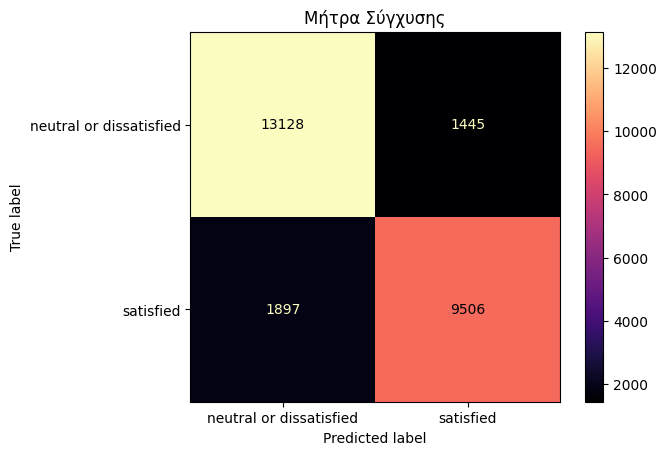

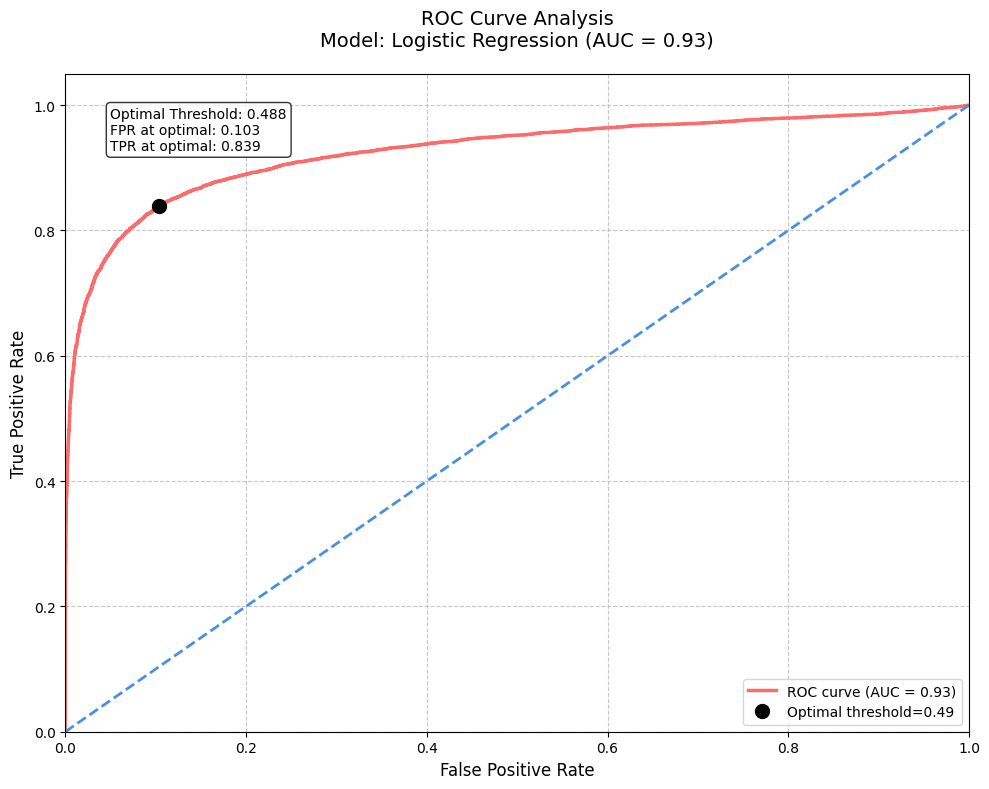


Detailed Metrics:
Optimal threshold: 0.488
At optimal threshold:
False Positive Rate: 0.103
True Positive Rate: 0.839


In [102]:
# Estimation and evaluation of the model
accuracy_logreg = accuracy_score(y_test, y_pred)
print(f"Accuracy: {accuracy_logreg:.2f}")

roc_auc_logreg = roc_auc_score(y_test, y_pred)
print(f"ROC_AUC: {roc_auc_logreg:.2f}")

# Print detailed classification report
print("\n\tClassification Report:")
print(classification_report(y_test, y_pred))

# Visualization 1: Confusion Matrix
conf_matrix = confusion_matrix(y_test, y_pred)
disp = ConfusionMatrixDisplay(confusion_matrix=conf_matrix, display_labels=class_labels)
disp.plot(cmap='magma')
plt.title("Μήτρα Σύγχυσης")
plt.show()

# Visualization 2: ROC-AUC curve
# Calculate prediction probabilities
y_pred_proba = logreg.predict_proba(X_test_scaled)[:, 1]

# Calculate ROC curve metrics
fpr, tpr, thresholds = roc_curve(y_test, y_pred_proba)
roc_auc = auc(fpr, tpr)

# Create the main plot with a clean, modern style
plt.figure(figsize=(10, 8), facecolor='white')

# Set background color
plt.gca().set_facecolor('white')

# Plot ROC curve
plt.plot(fpr, tpr, color='#FF6B6B', lw=2.5, 
         label=f'ROC curve (AUC = {roc_auc:.2f})')

# Plot the diagonal reference line
plt.plot([0, 1], [0, 1], color='#4A90E2', lw=2, linestyle='--')

# Set plot limits and labels
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate', fontsize=12)
plt.ylabel('True Positive Rate', fontsize=12)
plt.title('ROC Curve Analysis\n' + 
          f'Model: Logistic Regression (AUC = {roc_auc:.2f})',
          fontsize=14, pad=20)

# Add grid for better readability
plt.grid(True, linestyle='--', alpha=0.7)

# Find optimal threshold
threshold_idx = np.argmax(tpr - fpr)

# Add threshold points
plt.plot(fpr[threshold_idx], tpr[threshold_idx], 'ko', 
         markersize=10,
         label=f'Optimal threshold={thresholds[threshold_idx]:.2f}')

# Add legend with custom styling
plt.legend(loc='lower right', frameon=True, 
          framealpha=0.8, fontsize=10,
          bbox_to_anchor=(1.0, 0.0))

# Add text box with additional metrics
metrics_text = (f'Optimal Threshold: {thresholds[threshold_idx]:.3f}\n'
               f'FPR at optimal: {fpr[threshold_idx]:.3f}\n'
               f'TPR at optimal: {tpr[threshold_idx]:.3f}')

plt.text(0.05, 0.95, metrics_text,
         transform=plt.gca().transAxes,
         verticalalignment='top',
         bbox=dict(boxstyle='round', facecolor='white', alpha=0.8))

# Adjust layout
plt.tight_layout()

# Show plot
plt.show()

# Print additional metrics
print(f'\nDetailed Metrics:')
print(f'Optimal threshold: {thresholds[threshold_idx]:.3f}')
print(f'At optimal threshold:')
print(f'False Positive Rate: {fpr[threshold_idx]:.3f}')
print(f'True Positive Rate: {tpr[threshold_idx]:.3f}')

The code above performs the following steps to estimate and evaluate the **Logistic Regression** model:

1. **Accuracy calculation.**
2. **Calculation of the ROC AUC index.**
3. **Print detailed classification report.**
4. **Visualization of the Confusion Matrix.**

In [103]:
# Test with new observation
new_sample = np.zeros((1, X_train_scaled.shape[1]))
new_sample_scaled = StandardScaler().fit_transform(new_sample)
predicted_class = logreg.predict(new_sample_scaled)

# Map the predicted class to the corresponding string label
predicted_class_label = class_labels[predicted_class[0]]

print(f"\n\tThe forecast for the new sample: {predicted_class_label}\n")


	The forecast for the new sample: neutral or dissatisfied



The above code instantiates a new instance, transforms it, and predicts its class. Specifically:

1. **Create New Sample**: Creates a sample with zero values.
2. **Normalize**: Applies StandardScaler to scale the sample.
3. **Class Prediction**: Uses logistic regression model for prediction.
4. **Print Result**: Displays the predicted class of the sample.

In [105]:
# Evaluating the importance of features in prediction
# Using the model coefficients
# Get model coefficients
coefficients = logreg.coef_[0]
feature_importance = pd.DataFrame({
    'Feature': X_train.columns,
    'Coefficient': coefficients
}).sort_values('Coefficient', ascending=False)

print("Attribute Importance (Based on Factors):")
print(feature_importance)

Attribute Importance (Based on Factors):
                              Feature  Coefficient
3                      Type of Travel     1.269038
11                    Online boarding     0.832768
1                       Customer Type     0.772970
6               Inflight wifi service     0.510463
17                    Checkin service     0.412984
14                   On-board service     0.395317
4                               Class     0.342224
15                   Leg room service     0.334774
19                        Cleanliness     0.291788
16                   Baggage handling     0.162317
20         Departure Delay in Minutes     0.159468
18                   Inflight service     0.143991
12                       Seat comfort     0.094194
13             Inflight entertainment     0.078089
9                       Gate location     0.036901
5                     Flight Distance     0.004543
0                              Gender    -0.022422
10                     Food and drink    

The code above calculates feature importance using the coefficients of the logistic regression model and creates a table that ranks features according to their impact on prediction, identifying which features have the greatest or least influence on classification:

1. **Retrieving Model Coefficients.**
2. **Creating a Feature Importance Table.**
3. **Printing Feature Importance.**

To interpret the results of the code and identify the most and least important features, we need to look at the coefficients of the logistic regression model. Features with *larger* coefficients *(positive or negative)* are the *most important* for prediction. These have the greatest impact on classification, while features with *small or zero* coefficients have *less or no impact* on prediction.

### **1. Feature Importance**:
The `feature_importance` table created includes the features and their corresponding coefficients. These coefficients indicate how **relevant** each feature is for predicting the target category.

### **2. Interpretation of Coefficients**:
- **Positive Coefficients**: When a feature's coefficient is positive, it means that as the feature's value increases, the likelihood of the sample belonging to the "satisfied" category (or "1") increases.
- **Negative Coefficients**: If the coefficient is negative, then as the feature's value increases, the likelihood of the sample being "satisfied" decreases.
- **Zero or Small Coefficients**: If a coefficient is close to zero or very small, it means that the feature does not have a strong impact on predicting the category.

### **3. Most Important Features**:
- **Features with the largest (positive or negative) coefficients** are the most important. These have the **greatest impact** on the model's decision regarding the customer's category (satisfied or not).
- Conversely, if the coefficient is **negative and large**, it means the feature decreases the likelihood of the customer being satisfied.
- **Significant Features**:
  - `Type of Travel` (positive coefficient 1.269038): The prediction of overall customer satisfaction is greatly influenced by the purpose of the customer's travel.
  - `Online boarding` (positive coefficient 0.832768): The level of satisfaction with online boarding significantly impacts the prediction of overall satisfaction.
  - `Customer Type` (positive coefficient 0.772970): The frequency with which a customer chooses the airline, i.e., whether the customer is a frequent or infrequent traveler, significantly affects the prediction.

### **4. Least Important Features**:
- **Features with small or zero coefficients** have less or no impact on the model's decision. This means they do not significantly contribute to predicting customer satisfaction or dissatisfaction.

- **Less Significant Features**:
  - `Arrival Delay in Minutes` (negative coefficient -0.342616): The duration of the delay upon arrival has a notable impact on prediction. As this value increases, customer dissatisfaction is more likely.
  - `Departure/Arrival time convenient` (small negative coefficient -0.192377): Despite the small negative value, the level of satisfaction with departure and arrival times plays a significant role in overall satisfaction.
  - `Ease of Online booking` (small negative coefficient -0.192183): How easy a customer found the online booking process affects their overall satisfaction with the airline.

In [106]:
auc_scores = [accuracy_gnb, roc_auc_gnb, accuracy_logreg, roc_auc_logreg]
model_scores = pd.DataFrame(auc_scores, index=['Accuracy score Gaussian Naive Bayes','ROC-AUC score Gaussian Naive Bayes', 'Accuracy score Logistic Regression', 'ROC-AUC score Logistic Regression'], columns=['Scores'])
# Convert to percentage with 2 decimal places
model_scores['Scores'] = model_scores['Scores'].apply(lambda x: f"{x*100:.2f}%")
model_scores

,Scores
Accuracy score Gaussian Naive Bayes,86.19%
ROC-AUC score Gaussian Naive Bayes,85.74%
Accuracy score Logistic Regression,87.13%
ROC-AUC score Logistic Regression,86.72%


The code above compiles and presents the performance metrics for the Gaussian Naive Bayes and Logistic Regression models in a table, making it easier to compare the results:

1. **Creates a List `auc_scores`**:
   - The list contains four values corresponding to **performance metrics** for two models:
     - `accuracy_gnb`: The accuracy of the **Gaussian Naive Bayes** model.
     - `roc_auc_gnb`: The **ROC-AUC** score for the **Gaussian Naive Bayes** model.
     - `accuracy_logreg`: The accuracy of the **Logistic Regression** model.
     - `roc_auc_logreg`: The **ROC-AUC** score for the **Logistic Regression** model.

2. **Creates a `DataFrame` with the List Values**:
   - Uses the **`pandas`** library to create a table (DataFrame) with the performance metrics.
   - The table has two columns:
     - **`Scores`**: Contains the values of the performance metrics (such as accuracy and ROC-AUC).
     - **`index`**: Contains labels for each row, indicating which model and which metric (accuracy or ROC-AUC) it pertains to.

3. **Displays the `model_scores` Table**:
   - The table displays the performance metric values for the two models, facilitating the comparison of their performance.

The results in the table show the performance of two models, **Gaussian Naive Bayes** and **Logistic Regression**, based on two important performance metrics: **Accuracy** and **ROC-AUC**.

Let's explain each metric:

### **1. Accuracy Score**

**Accuracy** is the ratio of correct predictions to the total number of observations:

#### Results:
- **Gaussian Naive Bayes**: 0.861949 (86.19%)
  - The **Gaussian Naive Bayes** model correctly predicts 86.19% of the cases.
  
- **Logistic Regression**: 0.871343 (87.13%)
  - The **Logistic Regression** model has slightly better accuracy, at 87.13%.

### **2. ROC-AUC Score (Area Under the ROC Curve)**

The **ROC-AUC** metric evaluates the model's ability to correctly distinguish between categories (in this case, "satisfied" and "unsatisfied").
- **ROC-AUC** ranges from 0 to 1, with values close to 1 indicating excellent performance and values near 0.5 indicating random prediction.
  
#### Results:
- **Gaussian Naive Bayes**: 0.857421 (85.74%)
  - The **Gaussian Naive Bayes** has a **ROC-AUC** score of 85.74%, indicating good performance in distinguishing between categories.
  
- **Logistic Regression**: 0.867242 (86.72%)
  - The **Logistic Regression** has a slightly better **ROC-AUC** score (86.72%), meaning it has a slightly better ability to distinguish between categories than the **Gaussian Naive Bayes**.

### **Overall Comparison:**

- Both models perform excellently, with **Logistic Regression** slightly outperforming in both **accuracy** and **ROC-AUC**.
- **Gaussian Naive Bayes** also offers very good performance, with minor differences compared to **Logistic Regression**.

The results indicate that both models have **similar performance**, with **Logistic Regression** being slightly more accurate and better at distinguishing categories according to the **ROC-AUC** metric. However, the difference is small, and **Gaussian Naive Bayes** remains a very good choice for this problem.

## **Conclusion**

Based on the final evaluation results of the two models, the **Logistic Regression** slightly outperformed the **Gaussian Naive Bayes** classifier in predictions. A significant finding is the identification of two key variables/features that influence the overall customer/passenger satisfaction of the airline:

1. Travel Type:
   - Personal Travel
   - Business Travel

2. Customer Type:
   - Loyal Customer (Frequent Flyer)
   - Non-loyal Customer (Non-frequent Flyer)

These findings provide valuable insights for the airline company to:
- Better understand customer segmentation
- Focus on specific areas for service improvement
- Develop targeted marketing strategies
- Enhance customer experience based on travel and customer types

The model performance suggests that while both algorithms are effective, Logistic Regression provides marginally better predictive capability for this specific customer satisfaction analysis.

*Note: The model results can be used to develop more targeted approaches for improving customer satisfaction across different customer segments and travel purposes.*